In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import tabulate
import glob
import time
import re
import regionmask
import datetime
# to fix MJD
import astropy
from astropy.time import Time
import math

# data management
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon
from geospatial_functions import get_background_map

# imported from provided py code: long functions
from calc_geoid_change_alt import readstrokescoefficients, plm

In [2]:
# loading other layers
outline           = gpd.read_file(f"Data\\lena_basin_outline_polygon.gpkg",driver="GPKG")
main_rivers       = gpd.read_file(f"Data\\lena_main_river.gpkg",driver="GPKG")   
coast             = gpd.read_file(f"Data\\north_east_russian_coastlines.gpkg",driver="GPKG")   
# fixing crs
for layer in [outline,main_rivers,coast]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

# Load in stokes coefficients data
Downloaded data can be loaded in, note using stokes coefficients till 60th

In [3]:
grace_files = glob.glob('Data\\Grace_filtered\*.gfc')
love_numbers_kl = np.loadtxt('Data\\loadLoveNumbers_60.txt')[:,1]
l = 60
m = 60

Stokes coeffcients order 1& 2 need to be handeled differently

order 1: 

In [4]:
fname_stoke_coeff1 = f'Data\\Grace\\degree1_stokes_coeff.txt'
df_stokes_1 = pd.read_csv(fname_stoke_coeff1,skiprows=116,delimiter="\s+", 
        names=['GRCOF2',"l","m", "Clm","Slm","sd_Clm","sd_Slm","begin_date","end_date"])
### drop unwanted
df_stokes_1.drop(columns=["GRCOF2","sd_Clm","sd_Slm"],inplace=True)
### Reformat dates
df_stokes_1["end_date"] = df_stokes_1.apply(lambda x: pd.Timestamp(f'{str(x.end_date)[0:4]}-{str(x.end_date)[4:6]}-{str(x.end_date)[6:8]}'),axis=1)
### dirty fix to make more fit
df_stokes_1["begin_date"] = df_stokes_1.apply(lambda x: pd.Timestamp(f'{str(x.begin_date)[0:4]}-{str(x.begin_date)[4:6]}-01'),axis=1)

In [5]:
df_1_0 = df_stokes_1[df_stokes_1['m'] == 0].set_index('begin_date')
df_1_1 = df_stokes_1[df_stokes_1['m'] == 1].set_index('begin_date')

In [6]:
# easiest way to fix the indexing in matchting the correct indexes
df_index_replace = df_1_1.index.to_numpy().copy()
for i, index in enumerate(df_1_1.index):
    if i == 0:
        pass
    if (df_1_1.index[i-1] - index) == pd.Timedelta(0):
        replace = pd.Timestamp(f'{index.year}-{index.month+1}-{index.day}')
        df_index_replace[i] = replace
df_1_1.index = df_index_replace
df_1_0.index = df_index_replace

order 2,0 & 3,0:

In [7]:
def MJD_to_ts(mjd):
    ## thanks to https://stackoverflow.com/questions/72597699/how-do-i-convert-mjdjulian-date-to-utc-using-astropy
    # Start with some time in modified julian date (MJD)
    # Convert to Julian Date
    mjd = float(mjd)
    jd = mjd + 2400000.5
    # Convert to astropy Time object
    t = astropy.time.Time(jd, format='jd')
    # Convert to datetime
    str = t.to_datetime()
    return str

In [8]:
fname_stoke_coeff2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
col_names = ['MJD begin',"Year fraction begin","C20","C20 - C20_mean (1.0E-10)","sig_C20 (1.0E-10)", 
             "C30","C30 - C30_mean (1.0E-10)","sig_C30 (1.0E-10)",'MJD end',"Year fraction end"]
df_stokes_2_3 = pd.read_csv(fname_stoke_coeff2,skiprows=37,delimiter="\s+",names=col_names)
# fix date format
df_stokes_2_3["begin_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3["end_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3 = df_stokes_2_3[["begin_date","C20","C30","end_date"]].set_index("begin_date")

# allign indexes and replace like in C_1_1..
df_stokes_2_3 = df_stokes_2_3.iloc[:-2] # remove last two months to make same length
df_stokes_2_3.index = df_index_replace

Add trend due to Glacial isostatic adjustment ? 

In [9]:
fname_gia = f'Data\\GIA\\GIA_stoke_coeff_trend.gz'
df_1 = pd.read_csv(fname_gia, compression='gzip',skiprows=1,nrows=6,names=["l","m","Clm","Slm"],delimiter="\s+")
# df_2 = pd.read_csv(fname_gia, compression='gzip',skiprows=9,nrows=6,names=["l","m","Clm","Slm"],delimiter="\s+")
df_3 = pd.read_csv(fname_gia, compression='gzip',skiprows=17,names=["l","m","Clm","Slm"],delimiter="\s+")

df_combined = pd.concat([df_1, df_3])
df_combined["l"] = df_combined["l"].astype(int)
df_combined["m"] = df_combined["m"].astype(int)

In [10]:
GIA_C = np.zeros((l+1, m+1))
GIA_S = np.zeros((l+1, m+1))
for index, row in df_combined.iterrows():
    if row.m <= m and row.l <= l:
        GIA_C[int(row.m),int(row.l)] = row["Clm"]
        GIA_S[int(row.m),int(row.l)] = row["Slm"]

Adjust readstokescoefficients to also obtain `time_period_of_data`

In [11]:
def readstrokescoefficients_filtered(filename):
    with open(filename) as f:
        reach_end_of_head = 0
        for line in f:
            line = line.strip()
            if reach_end_of_head == 0:
                if line.startswith("earth_gravity_constant"):
                    GM = float(line[line.index(" ") + 1:])
                elif "radius" in line:
                    line = re.sub(' +', ' ', line)
                    R = float(line.split(" ")[1])
                elif line.startswith("max_degree"):
                    line = re.sub(' +', ' ', line)
                    max_degree = int(line.split(" ")[1])
                    C = np.zeros((max_degree + 1, max_degree + 1))
                    S = np.zeros((max_degree + 1, max_degree + 1))
                elif line.startswith('time_period_of_data'):
                    line = re.sub(' +', ' ', line)
                    date_line = line.split(" ")
                    begin_date = str(line.split(" ")[1])
                    begin_date_ts = pd.Timestamp(f'{begin_date[0:4]}-{begin_date[4:6]}-01')
                    mid_date = end_date = str(line.split(" ")[-1])
                    mid_date_ts = pd.Timestamp(f'{mid_date[0:4]}-{mid_date[4:6]}-{mid_date[6:8]}')
                    end_date = str(line.split(" ")[3])
                    end_date_ts = pd.Timestamp(f'{end_date[0:4]}-{end_date[4:6]}-{end_date[6:8]}')
                    date_lst = [begin_date_ts,mid_date_ts,end_date_ts]
                    
                else:
                    if line.startswith("end_of_head"):
                        reach_end_of_head = 1
            else:
                line = re.sub(' +', ' ', line)
                line = line.split()
                L = int(line[1])
                M = int(line[2])
                C[L, M] = float(line[3])
                S[L, M] = float(line[4])
    return C, S, R, GM, date_lst


In [12]:
# load in all coefficient
C, S, times, grace_names = [], [], [], []
plot_times = []
for i, file in enumerate(grace_files):
    C_i, S_i, R, GM, [begin_date_ts, mid_date_ts, end_date_ts] = readstrokescoefficients_filtered(file)
    time_i = begin_date_ts
    if i == 0:
        time_0 = time_i
    # replace C_1_0,C_1_1, S_1_1, C_2_0, C_3_0
    try:
        test  = df_1_0.loc[time_i,"Clm"]
        new_time = time_i
    except KeyError: # issue with finding correct value, this is easiest fix
        new_time = pd.Timestamp(f'{time_i.year}-{time_i.month-1}-{time_i.day}')
        print(new_time)
    
    C_i[1,0]  = df_1_0.loc[new_time,"Clm"]
    C_i[1,1]  = df_1_1.loc[new_time,"Clm"]
    S_i[1,1]  = df_1_1.loc[new_time,"Slm"]
    C_i[2,0]  = df_stokes_2_3.loc[new_time,"C20"]
    C_30  = df_stokes_2_3.loc[new_time,"C30"]
    # print(C_30)
    if np.isnan(C_30): 
        pass
    else: 
        C_i[3,0] = C_30
    
    C.append(C_i), S.append(S_i), times.append(time_i), grace_names.append(f'{time_i.year}-{time_i.month}-{time_i.day}'), plot_times.append(mid_date_ts)

In [13]:
np.savetxt("Data\\grace_names_friendly.txt",np.array(grace_names),delimiter=" ", fmt="%s") 

# Process coefficients

In [14]:
# calculate means of coefficients
C = np.array(C)
S = np.array(S)
C_mean = C.sum(axis=0)/len(C)
S_mean = S.sum(axis=0)/len(S)

In [15]:
# remove mean coefficients
dc1_store_0 = []
ds1_store_0 = []
for i, c in enumerate(C):
    dc1 = C[i] - C_mean
    ds1 = S[i] - S_mean
    dc1_store_0.append(dc1)
    ds1_store_0.append(ds1)

In [16]:
# set up timeseries

In [17]:
df_time_series = pd.DataFrame(times, index=times)

for index, date in enumerate(df_time_series.index):
    if index > 0: 
        dt = date - df_time_series.index[index-1]
        df_time_series.loc[date,"months_delta"] =  dt.days//28
    else:
        df_time_series.loc[date,"months_delta"] = 0
df_time_series['t_months'] = df_time_series.months_delta.cumsum().apply(lambda x: int(x))
mid_point = df_time_series.iloc[-1].t_months//2
df_time_series[df_time_series['t_months'] == mid_point]
df_time_series['t_t_0'] = df_time_series.apply(lambda row: (row.t_months-mid_point)-0.5, axis=1)

In [18]:
df_time_series

,0,months_delta,t_months,t_t_0
2002-04-01,2002-04-01,0.0,0,-88.5
2002-05-01,2002-05-01,1.0,1,-87.5
2002-08-01,2002-08-01,3.0,4,-84.5
2002-09-01,2002-09-01,1.0,5,-83.5
2002-10-01,2002-10-01,1.0,6,-82.5
...,...,...,...,...
2017-01-01,2017-01-01,1.0,173,84.5
2017-03-01,2017-03-01,2.0,175,86.5
2017-04-01,2017-04-01,1.0,176,87.5
2017-05-01,2017-05-01,0.0,176,87.5


In [19]:
# remove trend signal

In [20]:
for i, c in enumerate(C):
    t = df_time_series.loc[times[i],'t_months']
    if type(t) == pd.core.series.Series:
        t = t.iloc[0]
    C[i] -= GIA_C * t
    S[i] -= GIA_S * t 

In [21]:
dc1_store_0 = np.array(dc1_store_0)
ds1_store_0 = np.array(ds1_store_0)
# remove mean
C_mean = dc1_store_0.sum(axis=0) / len(C)
S_mean = ds1_store_0.sum(axis=0) / len(S)
# remove mean coefficients
dc1_store = []
ds1_store = []
for i, c in enumerate(C):
    dc1 = dc1_store_0[i] - C_mean
    ds1 = ds1_store_0[i] - S_mean
    dc1_store.append(dc1)
    ds1_store.append(ds1)


using 
\begin{equation}
\delta h_w \left(\theta,\lambda\right) = \sum_{l,m=0}^{\infty}=\bar{C_{lm}^{\delta h_w}} \bar{Y}_{lm}\left(\theta,\lambda\right)
\end{equation}


In [22]:
rho_av__rho_w = 5.5 # aprox

In [23]:
dh_c1_store = []
dh_s1_store = []

for k, dc1 in enumerate(dc1_store):
    C_dhw_i_1 = np.zeros((l+1, l+1))
    S_dhw_i_1 = np.zeros((l+1, l+1))
    for i in range(l+1):
        for j in range(i+1):
            multiplication_factor = (R  * (2 * i + 1) * rho_av__rho_w) / ( 3 * (1 + love_numbers_kl[i]))
            C_dhw_i_1[i, j] = (dc1_store[k][i, j] * multiplication_factor)
            S_dhw_i_1[i, j] = (ds1_store[k][i, j] * multiplication_factor)
    dh_c1_store.append(C_dhw_i_1)
    dh_s1_store.append(S_dhw_i_1)

Create array of lat lon for the area: 

In [24]:
_lambda = np.pi/180 * np.arange(270,330,1) - np.pi # 90 - 150 # deg lon
theta = np.pi - np.pi/180 * np.arange(180-40, 180-10,1) # 80 - 50 deg lat

print('_lambda=',_lambda/np.pi*180)
print('\n')
print('theta=',theta/np.pi*180)

_lambda= [ 90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103.
 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117.
 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131.
 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149.]


theta= [40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25. 24. 23.
 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11.]


# Convert to Equivalent Water hight for each cell

This is how the loop looks, to speed it up it is run in parrallel in `multicore_raw.py`, thus here we only actually load in the netCDF files

In [25]:
# last run - not multicore: 2023-10-26 09:42:55.218272 - 2023-10-26 10:39:23.874429
run = False
debug = False

if debug:
    n=5                
    loop = dh_c1_store[:n]
    times = times[:n]      # debugging
    # fname = "Data\\anomally_waterhead_filtered_test.nc"
    if run: fname = "Data\\anomally_waterhead_filtered_test.nc"
    else: fname = "Data\\anomally_waterhead_filtered_test_multicore.nc"
else:
    loop = dh_c1_store
    if run: fname = "Data\\anomally_waterhead_filtered.nc"
    else: fname = "Data\\anomally_waterhead_filtered_multicore.nc"
if run:
    # this is a much slower method, faster is the `multicore_filtered.py` which uses multi proecessing 
    store_ewh_1 = []
    print(datetime.datetime.now())
    for z, dh_c1 in enumerate(loop): # debugging
        print(f'{z=}',end='\n')
        ewh_i_1 = np.zeros((len(theta), len(_lambda)))
        
        for i in range(len(theta)):                              # loop over all thetas
            print(f'{i=} (out of {len(theta)})',end='\r')
            P_lm = plm(theta[i], l)                              # all Legendre Functions for one theta
            for j in range(len(_lambda)):                        # loop over all lambdas
                for k in range(l+1):                             # loop over all degrees
                    for t in range(k+1):                         # loop over negative orders
                        sin_t_lambda = np.sin(t*_lambda[j])      # negative orders
                        cos_t_lambda = np.cos(t*_lambda[j])      # non-negative orders
                        # compute here equivalent water heights
                        ewh_i_1[i, j] = ewh_i_1[i, j] + (dh_s1_store[z][k, t] * P_lm[k, t] * sin_t_lambda)
                        ewh_i_1[i, j] = ewh_i_1[i, j] + (dh_c1_store[z][k, t] * P_lm[k, t] * cos_t_lambda)
        print('\r')
        store_ewh_1.append(ewh_i_1)

    # store after itteration
    ds = xr.DataArray(store_ewh_1, dims=("time","lat","lon"),coords={"lon":_lambda/np.pi*180,
                                                                 "lat": 90 - theta/np.pi*180,
                                                                 "time":times}, name="dh(m)")
    
    ds.to_netcdf(fname)
    print(datetime.datetime.now())
else:
    ## Data set is relatively small and multicorecomputing is done in `multicore_filtered.py` we only want to open the file when needed
    ds_in = xr.open_dataset(fname)
    ds = ds_in.load()
    ds_in.close()

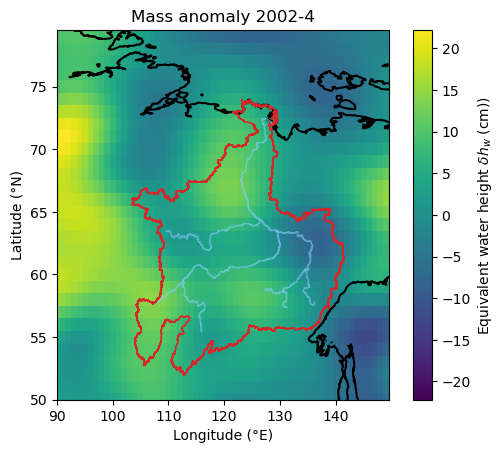

In [26]:
fig, ax = plt.subplots()
i = 0
plot_values = ds.isel(time=i)["dh(m)"] * 100
contour_plot = plot_values.plot(ax=ax,cmap="viridis")
contour_plot.colorbar.set_label("Equivalent water height $\delta h_w$ (cm))")

# ds.isel(time=i).plot(ax=ax,cmap="viridis")
ax.set_title(f"Mass anomaly {grace_names[i][:-2]}")
outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,lw=1)

ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
bounds = (90.0, 50.0, 149.5, 79.5)
coast.plot(ax=ax,color='k',zorder=1)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));

# Process grid data into time series

Mask the dat using [regionmask](https://regionmask.readthedocs.io/en/stable/)

In [27]:
mask = regionmask.mask_geopandas(outline, 
                                 ds.lon.to_numpy(), 
                                 ds.lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")

In [28]:
ds_lena_basin = ds.where(mask==0)

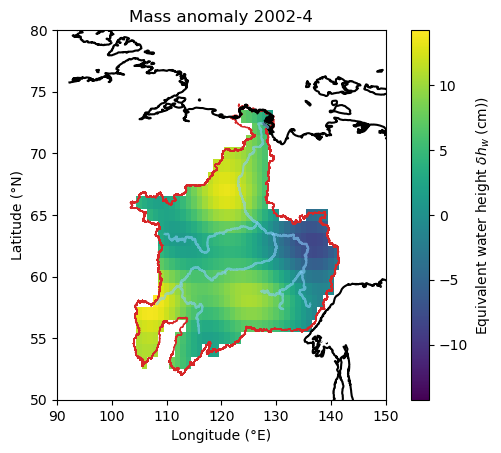

In [29]:
fig, ax = plt.subplots()
# ds_lena_basin.isel(time=i).plot(ax=ax,cmap="viridis")
plot_values = ds_lena_basin.isel(time=i)["dh(m)"] * 100
contour_plot = plot_values.plot(ax=ax,cmap="viridis")
contour_plot.colorbar.set_label("Equivalent water height $\delta h_w$ (cm))")
ax.set_title(f"Mass anomaly {grace_names[i][:-2]}")
outline.plot(ax=ax, edgecolor="C3", facecolor="None")
main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,lw=1.5)

bounds = (90.0, 50.0, 150.0, 80.0)
coast.plot(ax=ax,color='k',zorder=1)

ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
## optionally add background but CRS is difficult

# with rasterio.open(get_background_map("outline2", bounds)) as r:
#     rioshow(r, ax=ax,zorder=-10)
ax.set_xlim((bounds[0],bounds[2]))
ax.set_ylim((bounds[1],bounds[3]));

In [30]:
flat_mask = mask.values.flatten()
masked = len(flat_mask[~np.isnan(flat_mask)])
unmasked = len(flat_mask[np.isnan(flat_mask)])

In [31]:
d_lambda = (_lambda[1] - _lambda[0])
d_theta = (theta[0] - theta[1])
print(f'spatial resolution of a gridcell is {d_lambda*180/np.pi:.2f}deg lon, {d_theta*180/np.pi:.2f}deg lat')
mean_lambda = _lambda.mean()
mean_theta = theta.mean()
print(f'mean value a gridcell is {mean_lambda*180/np.pi:.2f}deg lon, {mean_theta*180/np.pi-90:.2f}deg lat')
distance_1deg_lat = 110.574 # km
distance_1deg_lon = 111.320 * np.cos((mean_theta*180/np.pi-90)*np.pi/180)# km
size_1_grid_cell = distance_1deg_lon * distance_1deg_lat
area_basin = size_1_grid_cell * masked

spatial resolution of a gridcell is 1.00deg lon, 1.00deg lat
mean value a gridcell is 119.50deg lon, -64.50deg lat


Move to a timeseries by averaging over the area: i.e. mean

In every case, grid values are weighted by cos(latitude), in order to obtain per surface unit values (cm/m²).

In [32]:
changes_total_water_mass = (ds_lena_basin.mean(dim=["lat","lon"])["dh(m)"] * 100)
# # fix time indexeing
# time_shift = changes_total_water_mass.time.to_numpy()
# changes_total_water_mass = changes_total_water_mass[2:-1]
# changes_total_water_mass['time'] = time_shift[3:]

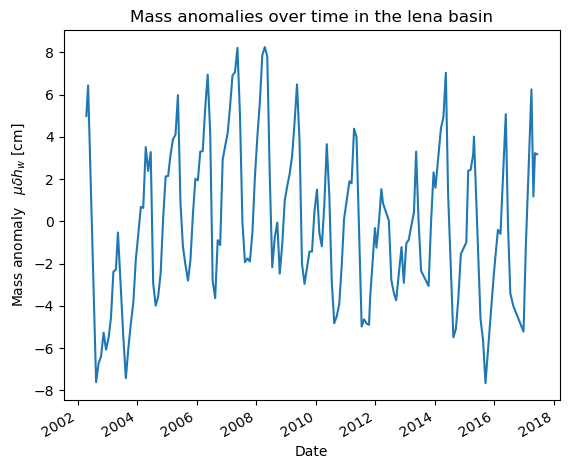

In [33]:
fig, ax = plt.subplots()
changes_total_water_mass.plot(ax=ax,)
ax.set_xlabel("Date")
ax.set_ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
ax.set_title("Mass anomalies over time in the lena basin"); 

first 3 months contain a lot of error: skip these:

In [34]:
changes_total_water_mass = (ds_lena_basin.mean(dim=["lat","lon"])["dh(m)"] * 100)
changes_total_water_mass = changes_total_water_mass[2:]

Repeat but for unfiltered stoke coefficients

In [35]:
fname_unfilted = "Data\\anomally_waterhead_raw_multicore.nc"
ds_unfilterd_in = xr.open_dataset(fname_unfilted)
ds_unfilterd = ds_unfilterd_in.load()
ds_unfilterd_in.close()
ds_lena_basin_unfilterd = ds_unfilterd.where(mask==0)
changes_total_water_mass_unfilterd = (ds_lena_basin_unfilterd.mean(dim=["lat","lon"])["dh(m)"] * 100)
changes_total_water_mass_unfilterd = changes_total_water_mass_unfilterd[2:]

In [36]:
fname_finer = "Data\\anomally_waterhead_filtered_multicore_finer_grid.nc"
ds_finer = xr.open_dataset(fname_finer)
ds_lena_basin_finer = ds_finer.where(mask==0)
changes_total_water_mass_finer = (ds_lena_basin_finer.mean(dim=["lat","lon"])["dh(m)"] * 100)
changes_total_water_mass_finer = changes_total_water_mass_finer[2:]

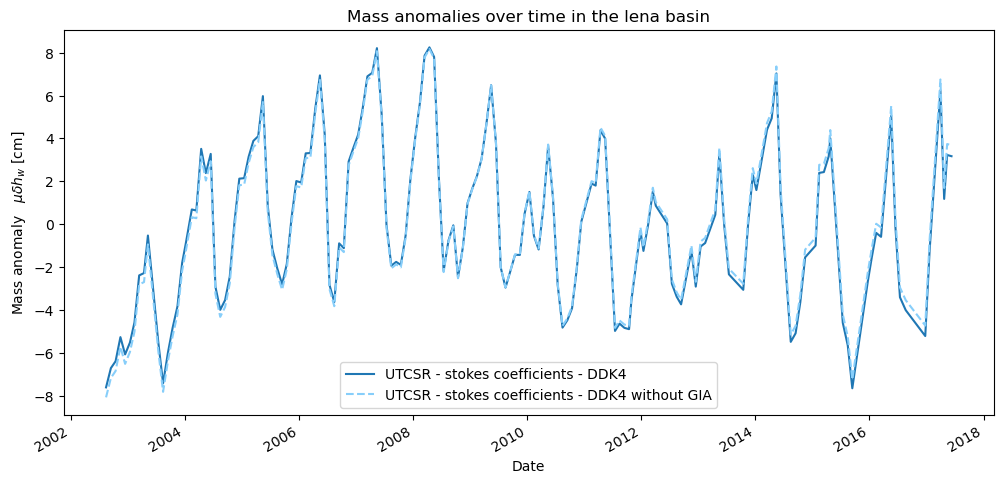

In [37]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(ds.time.to_numpy()[3:], changes_total_water_mass[2:-1],label="shifted")
changes_total_water_mass.plot(ax=ax,label="UTCSR - stokes coefficients - DDK4")
changes_total_water_mass_finer.plot(ax=ax,label="UTCSR - stokes coefficients - DDK4 without GIA",ls="--",color="lightskyblue")
ax.set_xlabel("Date")
ax.set_ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
ax.set_title("Mass anomalies over time in the lena basin"); 
ax.legend()
fig.savefig("Figures\mass anomalies over time.png")

reducing the grid size makes no difference, only used for comparison of GIA now

# Compare to other sources

Add data from [thegraceplotter.com](thegraceplotter.com)

In [38]:
def year_to_ts(time):
    ## thanks to https://stackoverflow.com/questions/20911015/decimal-years-to-datetime-in-python
    year = int(time)
    rem = time - year
    base = datetime.datetime(year, 1, 1)
    # result = base + datetime.timedelta(seconds=rem*365.25*24*3600) 
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    return result

In [39]:
df_graceplotter = pd.read_csv("Data\\Graceplotter_data_lenabasin.txt",delimiter="\s+",skiprows=463,names=["Time_S","Time_D_1950","Time_y","EWH","Lin","Predic"])
df_graceplotter['EWH'] = df_graceplotter.apply(lambda x: float(x["EWH"]) if x["EWH"] != " NaN" else np.nan,axis=1)
df_graceplotter = df_graceplotter.dropna()
df_graceplotter = df_graceplotter.iloc[2:]

In [40]:
df_graceplotter.index = df_graceplotter['Time_y'].apply(year_to_ts)

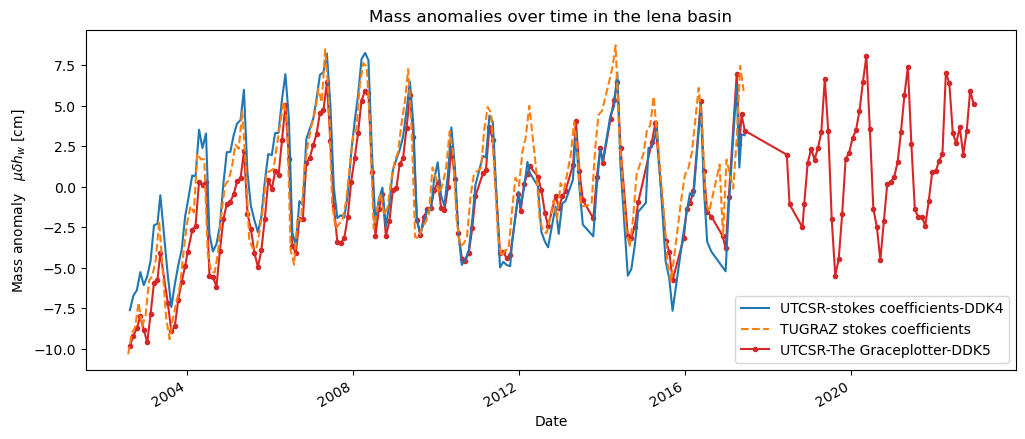

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
# ax.plot(ds.time.to_numpy()[3:], changes_total_water_mass[2:-1],label="shifted")
changes_total_water_mass.plot(ax=ax,label="UTCSR-stokes coefficients-DDK4")
changes_total_water_mass_unfilterd.plot(ax=ax,label="TUGRAZ stokes coefficients",ls="--")

df_graceplotter["EWH"].plot(ax=ax,label="UTCSR-The Graceplotter-DDK5",marker=".",color="C3",zorder=-1)

ax.set_xlabel("Date")
ax.set_ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
ax.set_title("Mass anomalies over time in the lena basin"); 


ax.legend(loc="lower right")
fig.savefig("Figures\mass anomalies over time.png")

In [42]:
# fig, ax = plt.subplots()
# changes_total_water_mass_km[:130].plot(ax=ax)
# ax.set_xlabel("Date")
# ax.set_ylabel("Mass anomaly   $\sum \delta h_w$ [km^3]")
# ax.set_title("Mass anomalies over time in the lena basin"); 

# Trend analysis

In [43]:
def rmse(predictions, targets): 
  "Computation of the rms difference between two data series"
  rmse = np.sqrt(((predictions - targets) ** 2).mean())
  return rmse

## Annual signal 
\begin{equation}
f(t)=A+B(t-t_0)+C(t-t_0)^2+D\sin{\omega}(t-t_0)+E\cos{\omega}(t-t_0)
\end{equation}

In [44]:
df_time_series_cropped = pd.DataFrame(times[2:], index=times[2:]) # discard first 2 months for trend analysis

for index, date in enumerate(df_time_series_cropped.index):
    if index > 0: 
        dt = date - df_time_series_cropped.index[index-1]
        df_time_series_cropped.loc[date,"months_delta"] =  dt.days//28
    else:
        df_time_series_cropped.loc[date,"months_delta"] = 0
df_time_series_cropped['t_months'] = df_time_series_cropped.months_delta.cumsum().apply(lambda x: int(x))
mid_point = df_time_series_cropped.iloc[-1].t_months//2
midpoint_date = df_time_series_cropped[df_time_series_cropped['t_months'] == mid_point].index[0]
df_time_series_cropped['t_t_0'] = df_time_series_cropped.apply(lambda row: (row.t_months-mid_point)-0.5, axis=1)

In [45]:
print(f'midpoint date: {midpoint_date}')

midpoint date: 2009-10-01 00:00:00


In [46]:
df_time_series_cropped_filtered = df_time_series_cropped.copy()
df_time_series_cropped_filtered['mass_anomaly'] = changes_total_water_mass.values

In [47]:
# prepare initial values
A, B, C, D, E = 1,1,1,1,1
param_0 = np.array([A,B,C,D,E])

In [48]:
def evaluate_matrix(x, df, diff=True):
    t_t0_array = df.t_t_0.values
    obs  = df.mass_anomaly.values
    n = 5
    T = 12 # or maybe 12 months? as t is still in months? -> 12 months!
    omega = 2 * np.pi / T
    A = np.zeros((len(t_t0_array),n))
    for i, t_t0 in enumerate(t_t0_array):
        A[i] = np.array([1, t_t0, t_t0**2, np.sin(omega * t_t0), np.cos(omega * t_t0)])
    d =  A @ x
    if not diff:
        # print("Returining values not residuals")
        return d, A
    else:
        return d - obs 

In [49]:
_, A_matrix = evaluate_matrix(param_0, df=df_time_series_cropped_filtered,diff=False)
x_bar = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_cropped_filtered.mass_anomaly.values
tabulate.tabulate([x_bar],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm]
1.14351,0.00144181,-0.00047438,2.51299,-1.62701


In [50]:
approximated_values, A_matrix = evaluate_matrix(x=x_bar, df=df_time_series_cropped_filtered, diff=False)

In [51]:
rmse_yaerly_whole = rmse(approximated_values, df_time_series_cropped_filtered.mass_anomaly.values)
print(f'The RMSE is {rmse_yaerly_whole:.2f}cm for a 3 linear trends')

The RMSE is 2.82cm for a 3 linear trends


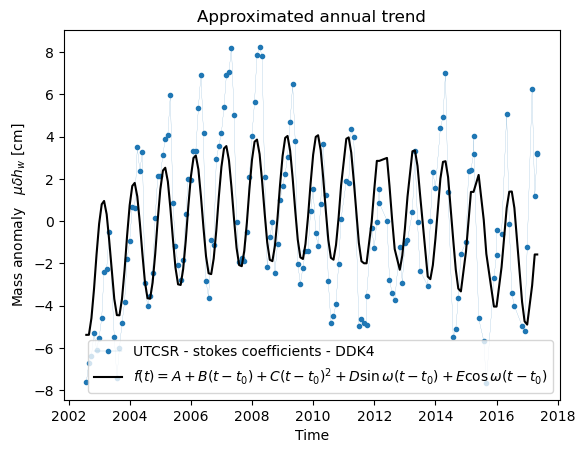

In [52]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values,label="$f(t)=A+B(t-t_0)+C(t-t_0)^2+D\sin{\omega}(t-t_0)+E\cos{\omega}(t-t_0)$",color="k")
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated annual trend")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## Single linear trend

In [53]:
def evaluate_matrix_linear(x, df, diff=True):
    t_t0_array = df.t_t_0.values
    obs  = df.mass_anomaly.values
    n = 2
    #T = 12 # or maybe 12 months? as t is still in months? -> 12 months!
    #omega = 2 * np.pi / T
    A = np.zeros((len(t_t0_array),n))
    for i, t_t0 in enumerate(t_t0_array):
        A[i] = np.array([1, t_t0]) #  t_t0**2, np.sin(omega * t_t0), np.cos(omega * t_t0)])
    d =  A @ x
    if not diff:
        # print("Returining values not residuals")
        return d, A
    else:
        return d - obs 

In [54]:
# prepare initial values
A, B, C, D, E = 1,1,1,1,1
param_0_lin = np.array([A,B]) #,C,D,E])

In [55]:
_, A_matrix = evaluate_matrix_linear(param_0_lin, df=df_time_series_cropped_filtered,diff=False)
x_bar_lin = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_cropped_filtered.mass_anomaly.values
tabulate.tabulate([x_bar_lin],headers=["A [cm]","B [cm/month]"],tablefmt="html")

A [cm],B [cm/month]
-0.0627282,0.00233344


In [56]:
print(f"Trend = {x_bar_lin[1] * 12*10:.2f}mm/year")

Trend = 0.28mm/year


In [57]:
approximated_values_linear_whole, A_matrix = evaluate_matrix_linear(x=x_bar_lin, df=df_time_series_cropped_filtered, diff=False)

In [58]:
rmse_lin_whole = rmse(approximated_values_linear_whole, df_time_series_cropped_filtered.mass_anomaly.values)
print(f'The RMSE is {rmse_lin_whole:.2f}cm for a linear trend')

The RMSE is 3.71cm for a linear trend


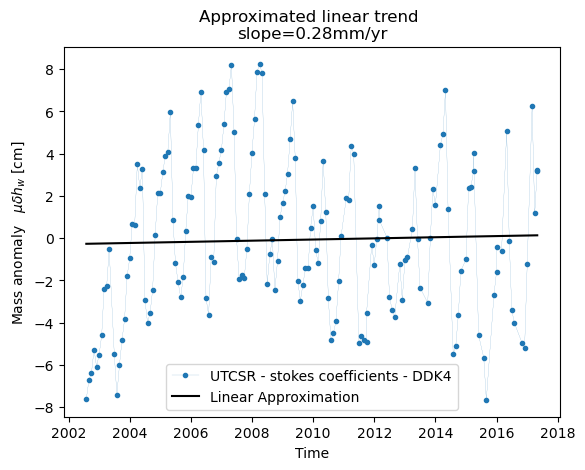

In [59]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values_linear_whole,label="Linear Approximation", color="k")
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title(f"Approximated linear trend \nslope={x_bar_lin[1] * 12*10:.2f}mm/yr")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## Split into three sections & compute linear trend

In [60]:
df_time_series_filtered_02_07 = df_time_series_cropped_filtered.loc[:"2006"]
_, A_matrix = evaluate_matrix_linear(param_0_lin, df=df_time_series_filtered_02_07,diff=False)
x_bar_02_07 = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_filtered_02_07.mass_anomaly.values
tabulate.tabulate([x_bar_02_07],headers=["A [cm]","B [cm/month]"],tablefmt="html")

approximated_values_linear_02_07, A_matrix = evaluate_matrix_linear(x=x_bar_02_07, df=df_time_series_filtered_02_07, diff=False)

In [61]:
df_time_series_filtered_07_12 = df_time_series_cropped_filtered.loc["2007":"2011"]
_, A_matrix = evaluate_matrix_linear(param_0_lin, df=df_time_series_filtered_07_12,diff=False)
x_bar_07_12 = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_filtered_07_12.mass_anomaly.values
tabulate.tabulate([x_bar_07_12],headers=["A [cm]","B [cm/month]"],tablefmt="html")

approximated_values_linear_07_12, A_matrix = evaluate_matrix_linear(x=x_bar_07_12, df=df_time_series_filtered_07_12, diff=False)

In [62]:
df_time_series_filtered_12_17 = df_time_series_cropped_filtered.loc["2012":"2017"]
_, A_matrix = evaluate_matrix_linear(param_0_lin, df=df_time_series_filtered_12_17 ,diff=False)
x_bar_12_17  = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_filtered_12_17 .mass_anomaly.values
tabulate.tabulate([x_bar_12_17 ],headers=["A [cm]","B [cm/month]"],tablefmt="html")

approximated_values_linear_12_17 , A_matrix = evaluate_matrix_linear(x=x_bar_12_17 , df=df_time_series_filtered_12_17 , diff=False)

In [63]:
x_bar_02_07[1] = x_bar_02_07[1] * 12
x_bar_07_12[1] = x_bar_07_12[1] * 12 
x_bar_12_17[1] = x_bar_12_17[1] * 12
tabulate.tabulate([x_bar_02_07,x_bar_07_12,x_bar_12_17],headers=["A [cm]","B [cm/yr]"],tablefmt="html")

A [cm],B [cm/yr]
8.83664,1.91569
0.333621,-1.3918
-0.684559,0.0509571


In [64]:
combined_vals_3_lin = np.hstack([approximated_values_linear_02_07,
                                approximated_values_linear_07_12,
                                approximated_values_linear_12_17])
combined_obs_3_lin = np.hstack([df_time_series_filtered_02_07.mass_anomaly.values,
                               df_time_series_filtered_07_12.mass_anomaly.values,
                               df_time_series_filtered_12_17.mass_anomaly.values])

In [65]:
rmse_lin_whole = rmse(combined_vals_3_lin, combined_obs_3_lin)
print(f'The RMSE is {rmse_lin_whole:.2f}cm for a 3 linear trends')

The RMSE is 3.15cm for a 3 linear trends


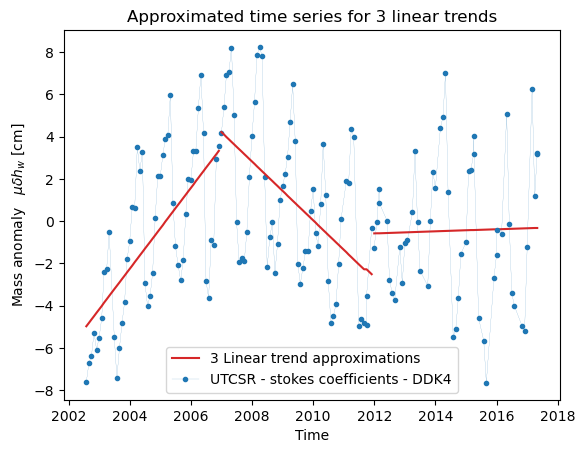

In [66]:
plt.plot(df_time_series_filtered_02_07.index, df_time_series_filtered_02_07.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_02_07.index, approximated_values_linear_02_07,color="C3")

plt.plot(df_time_series_filtered_07_12.index, df_time_series_filtered_07_12.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_07_12.index, approximated_values_linear_07_12,color="C3")

plt.plot(df_time_series_filtered_12_17.index, approximated_values_linear_12_17,label="3 Linear trend approximations",color="C3")
plt.plot(df_time_series_filtered_12_17.index, df_time_series_filtered_12_17.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4",color="C0")


plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated time series for 3 linear trends")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## Single quadratic trend

In [67]:
def evaluate_matrix_quadratic(x, df, diff=True):
    t_t0_array = df.t_t_0.values
    obs  = df.mass_anomaly.values
    n = 3
    #T = 12 # or maybe 12 months? as t is still in months? -> 12 months!
    #omega = 2 * np.pi / T
    A = np.zeros((len(t_t0_array),n))
    for i, t_t0 in enumerate(t_t0_array):
        A[i] = np.array([1, t_t0, t_t0**2]) #  t_t0**2, np.sin(omega * t_t0), np.cos(omega * t_t0)])
    d =  A @ x
    if not diff:
        # print("Returining values not residuals")
        return d, A
    else:
        return d - obs 

In [68]:
# prepare initial values
A, B, C, D, E = 1,1,1,1,1
param_0_quad = np.array([A,B,C]) # ,D,E])

In [69]:
_, A_matrix = evaluate_matrix_quadratic(param_0_quad, df=df_time_series_cropped_filtered,diff=False)
x_bar_quad = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_cropped_filtered.mass_anomaly.values
tabulate.tabulate([x_bar_quad],headers=["A [cm]","B [cm/month]", "C [cm/month^2]"],tablefmt="html")
approximated_values_quad, A_matrix = evaluate_matrix_quadratic(x=x_bar_quad, df=df_time_series_cropped_filtered, diff=False)

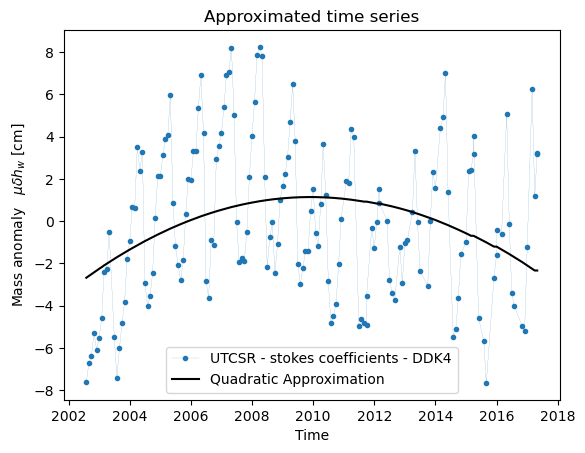

In [70]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values_quad,label="Quadratic Approximation",color='k')
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated time series")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## single cubic trend

In [71]:
def evaluate_matrix_cubic(x, df, diff=True):
    t_t0_array = df.t_t_0.values
    obs  = df.mass_anomaly.values
    n = 4
    #T = 12 # or maybe 12 months? as t is still in months? -> 12 months!
    #omega = 2 * np.pi / T
    A = np.zeros((len(t_t0_array),n))
    for i, t_t0 in enumerate(t_t0_array):
        A[i] = np.array([1, t_t0, t_t0**2,t_t0**3]) #  t_t0**2, np.sin(omega * t_t0), np.cos(omega * t_t0)])
    d =  A @ x
    if not diff:
        # print("Returining values not residuals")
        return d, A
    else:
        return d - obs 

In [72]:
# prepare initial values
A, B, C, D, E = 1,1,1,1,1
param_0_cube = np.array([A,B,C,D]) #,E])

In [73]:
_, A_matrix = evaluate_matrix_cubic(param_0_cube, df=df_time_series_cropped_filtered,diff=False)
x_bar_cube = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_cropped_filtered.mass_anomaly.values
tabulate.tabulate([x_bar_cube],headers=["A [cm]","B [cm/month]", "C [cm/month^2]","D[cm/month^3]"],tablefmt="html")
approximated_values_cube, A_matrix = evaluate_matrix_cubic(x=x_bar_cube, df=df_time_series_cropped_filtered, diff=False)

In [74]:
rmse_cube_whole = rmse(approximated_values_cube, df_time_series_cropped_filtered.mass_anomaly.values)
print(f'The RMSE is {rmse_cube_whole:.2f}cm for a cubic trend')

The RMSE is 3.21cm for a cubic trend


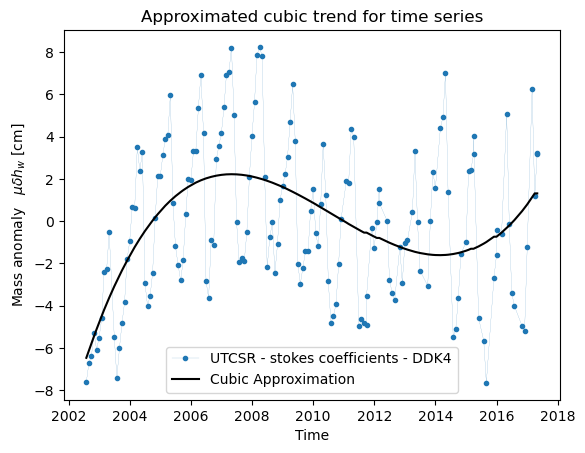

In [75]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values_cube,label="Cubic Approximation",color='k')
# plt.plot(df_time_series_annually.index, df_time_series_annually.mass_anomaly,lw=0.4, marker="*",label="Annual mean",color="C2")

plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated cubic trend for time series")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## Combine Cubic, annual mean & three trend

In [76]:
df_time_series_annually = df_time_series_cropped_filtered.resample("a").mean("mass_anomaly").loc[:"2016"]
df_time_series_annually_min = df_time_series_cropped_filtered.resample("a").min("mass_anomaly").loc[:"2016"]
df_time_series_annually_max = df_time_series_cropped_filtered.resample("a").max("mass_anomaly").loc[:"2016"]
df_time_series_annually_range = df_time_series_annually_max - df_time_series_annually_min 

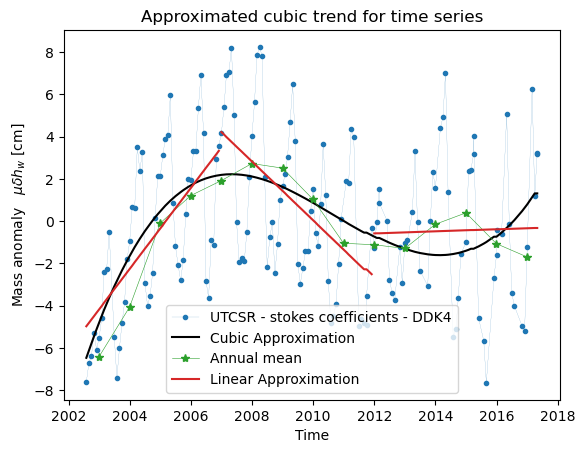

In [77]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values_cube,label="Cubic Approximation",color='k')

plt.plot(df_time_series_annually.index, df_time_series_annually.mass_anomaly,lw=0.4, marker="*",label="Annual mean",color="C2")

plt.plot(df_time_series_filtered_02_07.index, approximated_values_linear_02_07,label="Linear Approximation",color="C3")
plt.plot(df_time_series_filtered_07_12.index, approximated_values_linear_07_12,color="C3")
plt.plot(df_time_series_filtered_12_17.index, approximated_values_linear_12_17,color="C3")

plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated cubic trend for time series")
plt.legend(loc="lower center");

## Cubic in annual signal
\begin{equation}
f(t)=A+B(t-t_0)+C(t-t_0)^2+F(t-t_0)^3+D\sin{\omega}(t-t_0)+E\cos{\omega}(t-t_0)
\end{equation}

In [78]:
def evaluate_matrix_annual_and_cubic(x, df, diff=True):
    t_t0_array = df.t_t_0.values
    obs  = df.mass_anomaly.values
    n = 6
    T = 12 # or maybe 12 months? as t is still in months? -> 12 months!
    omega = 2 * np.pi / T
    A = np.zeros((len(t_t0_array),n))
    for i, t_t0 in enumerate(t_t0_array):
        A[i] = np.array([1, t_t0, t_t0**2,t_t0**3, np.sin(omega * t_t0), np.cos(omega * t_t0)])
    d =  A @ x
    if not diff:
        # print("Returining values not residuals")
        return d, A
    else:
        return d - obs 

In [79]:
# prepare initial values
A, B, C, D, E,F = 1,1,1,1,1,1
param_0_annual_cubic = np.array([A,B,C,D,E,F])

In [80]:
_, A_matrix = evaluate_matrix_annual_and_cubic(param_0_annual_cubic, df=df_time_series_cropped_filtered,diff=False)
x_bar_annual_cubic = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_cropped_filtered.mass_anomaly.values
tabulate.tabulate([x_bar_annual_cubic],headers=["A [cm]","B [cm/month]","C [cm/month^2]","F[cm/month^3]","D [cm]","E [cm]"],tablefmt="html")

A [cm],B [cm/month],C [cm/month^2],F[cm/month^3],D [cm],E [cm]
1.04224,-0.0655531,-0.000452427,1.47617e-05,2.47976,-1.61073


In [81]:
approximated_values_annual_cubic, A_matrix = evaluate_matrix_annual_and_cubic(x=x_bar_annual_cubic, df=df_time_series_cropped_filtered, diff=False)

In [82]:
rmse_yaerly_whole = rmse(approximated_values_annual_cubic, df_time_series_cropped_filtered.mass_anomaly.values)
print(f'The RMSE is {rmse_yaerly_whole:.2f}cm for a qubic annual trend')

The RMSE is 2.41cm for a qubic annual trend


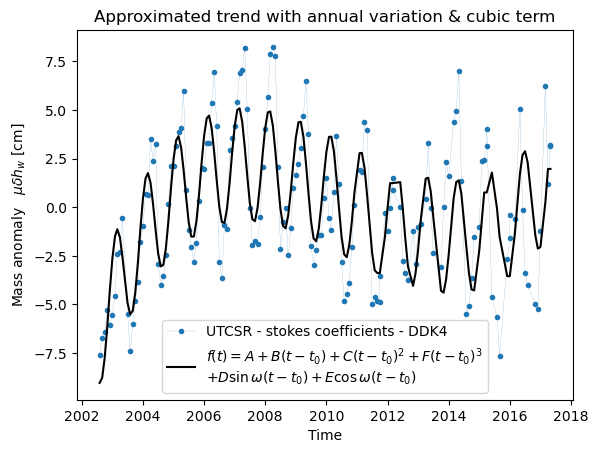

In [83]:
plt.plot(df_time_series_cropped_filtered.index, df_time_series_cropped_filtered.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4")
plt.plot(df_time_series_cropped_filtered.index, approximated_values_annual_cubic,label="$f(t)=A+B(t-t_0)+C(t-t_0)^2+F(t-t_0)^3$\n$+D\sin{\omega}(t-t_0)+E\cos{\omega}(t-t_0)$",color="k")
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated trend with annual variation & cubic term")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## split into 3 intervals, parameters
but also estimate std of errors and compare - residuals like in wk 4

In [84]:
df_time_series_filtered_02_07 = df_time_series_cropped_filtered.loc[:"2007-02"]
_, A_matrix_02_07 = evaluate_matrix(param_0, df=df_time_series_filtered_02_07,diff=False)
x_bar_02_07 = np.linalg.inv(A_matrix_02_07.T @ A_matrix_02_07) @ A_matrix_02_07.T @ df_time_series_filtered_02_07.mass_anomaly.values
tabulate.tabulate([x_bar_02_07],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")
approximated_values_linear_02_07, _ = evaluate_matrix(x=x_bar_02_07, df=df_time_series_filtered_02_07, diff=False)

In [85]:
df_time_series_filtered_07_12 = df_time_series_cropped_filtered.loc["2007":"2012-02"]
_, A_matrix_07_12 = evaluate_matrix(param_0, df=df_time_series_filtered_07_12,diff=False)
x_bar_07_12 = np.linalg.inv(A_matrix_07_12.T @ A_matrix_07_12) @ A_matrix_07_12.T @ df_time_series_filtered_07_12.mass_anomaly.values
tabulate.tabulate([x_bar_07_12],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

approximated_values_linear_07_12, _ = evaluate_matrix(x=x_bar_07_12, df=df_time_series_filtered_07_12, diff=False)

In [86]:
df_time_series_filtered_12_17 = df_time_series_cropped_filtered.loc["2012-01":"2017"]
_, A_matrix_12_17 = evaluate_matrix(param_0, df=df_time_series_filtered_12_17 ,diff=False)
x_bar_12_17  = np.linalg.inv(A_matrix_12_17.T @ A_matrix_12_17) @ A_matrix_12_17.T @ df_time_series_filtered_12_17 .mass_anomaly.values
tabulate.tabulate([x_bar_12_17 ],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

approximated_values_linear_12_17 , _ = evaluate_matrix(x=x_bar_12_17 , df=df_time_series_filtered_12_17 , diff=False)

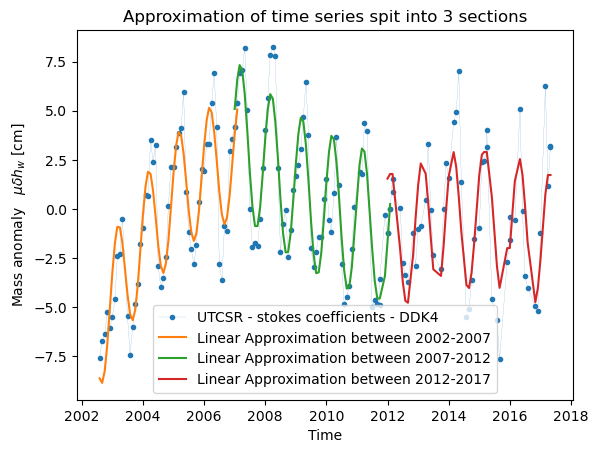

In [87]:
plt.plot(df_time_series_filtered_02_07.index, df_time_series_filtered_02_07.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_07_12.index, df_time_series_filtered_07_12.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_12_17.index, df_time_series_filtered_12_17.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4",color="C0")

plt.plot(df_time_series_filtered_02_07.index, approximated_values_linear_02_07,label="Linear Approximation between 2002-2007",color="C1")
plt.plot(df_time_series_filtered_07_12.index, approximated_values_linear_07_12,label="Linear Approximation between 2007-2012",color="C2")
plt.plot(df_time_series_filtered_12_17.index, approximated_values_linear_12_17,label="Linear Approximation between 2012-2017",color="C3")

plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximation of time series spit into 3 sections")
# plt.legend(bbox_to_anchor=(1,1));
plt.legend(loc="best");

### RMSE

In [88]:
combined_vals_3_lin = np.hstack([approximated_values_linear_02_07,
                                approximated_values_linear_07_12,
                                approximated_values_linear_12_17])
combined_obs_3_lin = np.hstack([df_time_series_filtered_02_07.mass_anomaly.values,
                               df_time_series_filtered_07_12.mass_anomaly.values,
                               df_time_series_filtered_12_17.mass_anomaly.values])

In [89]:
rmse_lin_whole = rmse(combined_vals_3_lin, combined_obs_3_lin)
print(f'The RMSE is {rmse_lin_whole:.2f}cm for a annual trends')

The RMSE is 1.84cm for a annual trends


Convert D and E to F and Phi
\begin{equation}
f(t)= ... + D \sin \omega\left(t-t_0\right)+E \cos \omega\left(t-t_0\right)
\end{equation}
\begin{equation}
f(t)= ... + F \sin \left(\omega \left(t-t_0\right) + \phi \right)
\end{equation}
\begin{equation}
F = \sqrt{D^2+E^2}
\end{equation}

\begin{equation}
\phi = atan2({\frac{D}{E}})
\end{equation}

In [90]:
F = [np.sqrt(D**2 + E**2) for D,E in [x_bar_02_07[-2:],x_bar_07_12[-2:],x_bar_12_17[-2:]]]
phi = [math.atan2(D,E) for D,E in [x_bar_02_07[-2:],x_bar_07_12[-2:],x_bar_12_17[-2:]]]
# day_of_func_max = [abs(365.25/4 -365.25 * phi_i/(2*np.pi)) for phi_i in phi]
day_of_func_max = [abs(365.25/4 - 365.25*phi_i/(2*np.pi)) for phi_i in phi]

In [91]:
tabulate.tabulate([["2002-2007"] + list(x_bar_02_07) + [F[0],phi[0],day_of_func_max[0]],
                         ["2007-2012"] + list(x_bar_07_12) + [F[1],phi[1],day_of_func_max[1]],
                         ["2012-2017"] + list(x_bar_12_17) + [F[2],phi[2],day_of_func_max[2]],
                        ],#tablefmt="html")#,
                        floatfmt=[".2f",".2f",".2f",".4f",".2f",".2f",".2f",".2f",".0f"],
                        headers=["Years","A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]","F[cm]","Phi[rad]","T_f(max)[d]"],tablefmt="html")

Years,A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm],F[cm],Phi[rad],T_f(max)[d]
2002-2007,-0.03,-0.16,-0.0027,2.04,-2.38,3.14,2.43,50
2007-2012,0.32,-0.07,0.0010,2.09,-3.16,3.79,2.56,57
2012-2017,-4.65,0.14,-0.0013,3.21,1.50,3.54,1.13,25


#### show day of function maximum 

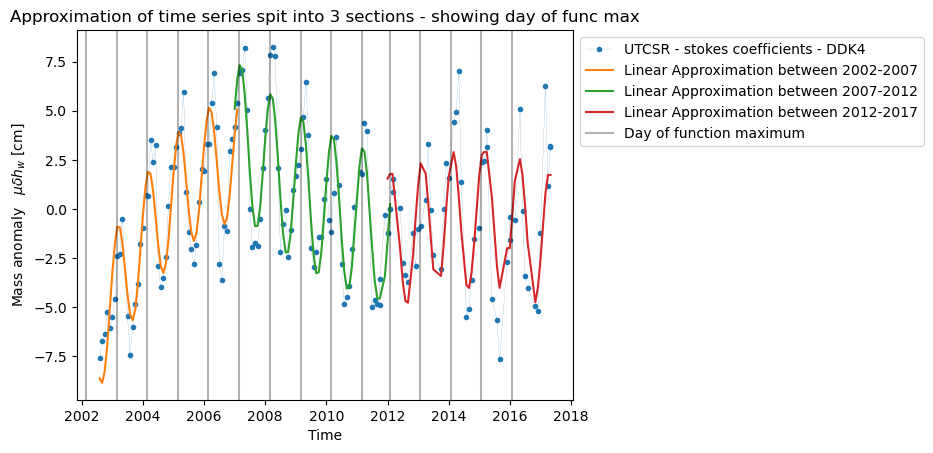

In [92]:
plt.plot(df_time_series_filtered_02_07.index, df_time_series_filtered_02_07.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_07_12.index, df_time_series_filtered_07_12.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_filtered_12_17.index, df_time_series_filtered_12_17.mass_anomaly,lw=0.1, marker=".",label="UTCSR - stokes coefficients - DDK4",color="C0")

plt.plot(df_time_series_filtered_02_07.index, approximated_values_linear_02_07,label="Linear Approximation between 2002-2007",color="C1")
plt.plot(df_time_series_filtered_07_12.index, approximated_values_linear_07_12,label="Linear Approximation between 2007-2012",color="C2")
plt.plot(df_time_series_filtered_12_17.index, approximated_values_linear_12_17,label="Linear Approximation between 2012-2017",color="C3")

plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximation of time series spit into 3 sections - showing day of func max")
# plt.legend(bbox_to_anchor=(1,1));

day_of_func_max
plt.axvline(pd.Timestamp(f"{2002}-01-01")+pd.Timedelta(day_of_func_max[0],unit="d"),color="k", alpha=0.3,label="Day of function maximum")
[plt.axvline(pd.Timestamp(f"{year}-01-01")+pd.Timedelta(day_of_func_max[0],unit="d"),color="k", alpha=0.3) for year in np.arange(2003,2007,1)]
[plt.axvline(pd.Timestamp(f"{year}-01-01")+pd.Timedelta(day_of_func_max[1],unit="d"),color="k", alpha=0.3) for year in np.arange(2007,2012,1)]
[plt.axvline(pd.Timestamp(f"{year}-01-01")+pd.Timedelta(day_of_func_max[2],unit="d"),color="k", alpha=0.3) for year in np.arange(2012,2017,1)]

plt.legend(bbox_to_anchor=(1,1));

### errors

In [93]:
residuals = combined_obs_3_lin - combined_vals_3_lin
n_p = 5 # number of parameters: A,B,C,D,E
sigma_d = np.sqrt(np.sum(residuals**2/(len(residuals)-n_p)))
print(f"unbiased estimation of sigma_d = {sigma_d:.3f}cm")

unbiased estimation of sigma_d = 1.868cm


In [94]:
matrices = [A_matrix_02_07 , A_matrix_07_12, A_matrix_12_17]
cov = [sigma_d**2 * np.linalg.inv((A.T @ A)) for A in matrices]
sig = [list(np.sqrt(np.diag(C))) for C in cov]

In [95]:
tabulate.tabulate([["2002-2007"] + sig[0],
                         ["2007-2012"] + sig[1],
                         ["2012-2017"] + sig[2]],
                          floatfmt=[".2f",".2f",".2f",".4f",".2f",".2f",".2f",".0f"],
                        headers=["Years","σA [cm]","σB [cm/month]","σC [cm/month^2]","σD [cm]","σE [cm]"],tablefmt="html")

Years,σA [cm],σB [cm/month],σC [cm/month^2],σD [cm],σE [cm]
2002-2007,3.89,0.14,0.0011,0.36,0.37
2007-2012,0.36,0.02,0.0009,0.34,0.35
2012-2017,2.54,0.10,0.0009,0.37,0.39


However we need to look af F and Phi
\begin{equation}
\sigma_F=\sqrt{\frac{D^2 \sigma^2_D +E^2 \sigma^2_E +2 D E \operatorname{cov}[D,E]}{D^2+E^2}}
\end{equation}

\begin{equation}
\sigma_{\phi}=\frac{\sqrt{E^2 \sigma^2_D +D^2 \sigma^2_E - 2 D E \operatorname{cov}[D, E]}}{D^2+E^2}
\end{equation}

In [96]:
for i, Cx in enumerate(cov):
    cov_D_E = Cx[3,4]
    cov_E_D = Cx[4,3]
    var_D = Cx[3,3]
    var_E = Cx[4,4]
    sigma_F = np.sqrt((D**2 * var_D + E**2 * var_E + 2 * D * E * cov_D_E)/(D**2 + E**2))
    sigma_phi = np.sqrt(E**2 * var_D + D**2 * var_E - 2 * D * E * cov_D_E)/(D**2 + E**2)
    sigma_phi_day = 365.25 * sigma_phi/(2*np.pi)
    sig[i] += [sigma_F, sigma_phi_day]

In [97]:
tabulate.tabulate([["2002-2007"] + sig[0],
                         ["2007-2012"] + sig[1],
                         ["2012-2017"] + sig[2]],
                        floatfmt=[".2f",".2f",".2f",".4f",".2f",".2f",".2f",".0f"],
                        headers=["Years","σA [cm]","σB [cm/month]","σC [cm/month^2]","σD [cm]","σE [cm]","σF [cm]","σPhi [d]"],tablefmt="html")

Years,σA [cm],σB [cm/month],σC [cm/month^2],σD [cm],σE [cm],σF [cm],σPhi [d]
2002-2007,3.89,0.14,0.0011,0.36,0.37,0.37,15
2007-2012,0.36,0.02,0.0009,0.34,0.35,0.35,14
2012-2017,2.54,0.10,0.0009,0.37,0.39,0.38,16


## Compare values and sigma

In [98]:
coeff_02_07 = list(x_bar_02_07) + [F[0],day_of_func_max[0]]
coeff_07_12 = list(x_bar_07_12) + [F[1],day_of_func_max[1]]
coeff_12_17 = list(x_bar_12_17) + [F[2],day_of_func_max[2]]
tabulate.tabulate([["2002-2007"] + coeff_02_07,
                         ["σ"] + sig[0],
                         ["2007-2012"] + coeff_07_12,
                         ["σ"] + sig[1],
                         ["2012-2017"] + coeff_12_17,
                         ["σ"] + sig[2],
                        ],
                    floatfmt=[".2f",".2f",".2f",".4f",".2f",".2f",".2f",".0f"],
                    headers=["Years","A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]","F[cm]","T_f(max)[d]"],tablefmt="html")

Years,A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm],F[cm],T_f(max)[d]
2002-2007,-0.03,-0.16,-0.0027,2.04,-2.38,3.14,50
σ,3.89,0.14,0.0011,0.36,0.37,0.37,15
2007-2012,0.32,-0.07,0.0010,2.09,-3.16,3.79,57
σ,0.36,0.02,0.0009,0.34,0.35,0.35,14
2012-2017,-4.65,0.14,-0.0013,3.21,1.50,3.54,25
σ,2.54,0.10,0.0009,0.37,0.39,0.38,16


<ErrorbarContainer object of 3 artists>

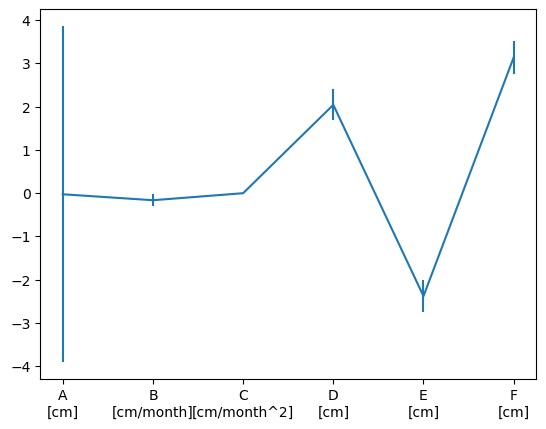

In [99]:
x_0 = ["A\n[cm]","B\n[cm/month]","C\n[cm/month^2]","D\n[cm]","E\n[cm]","F\n[cm]","T_f(max)\n[d]"]
x = x_0[:-1]
plt.errorbar(x, coeff_02_07[:-1] , yerr=sig[0][:-1])
# plt.errorbar(x, coeff_07_12[:-1] , yerr=sig[1][:-1])
# plt.errorbar(x, coeff_12_17[:-1] , yerr=sig[2][:-1]);

Text(0.5, 1.0, 'Coefficients with errors')

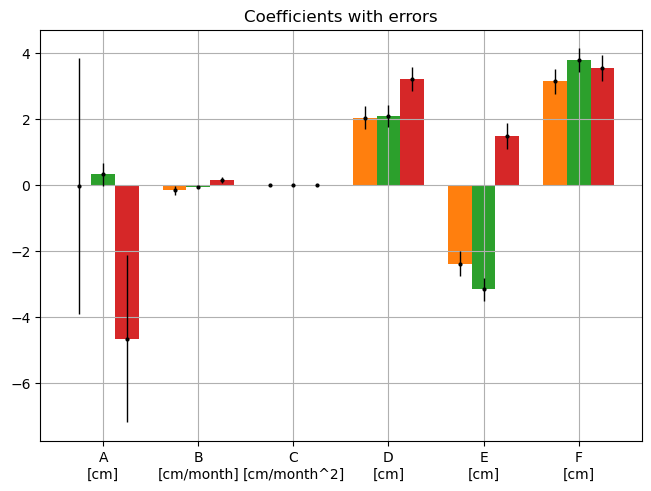

In [100]:
x_arr = np.arange(len(x))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
color=["C1","C2","C3"]
for index, measurement in enumerate([coeff_02_07,coeff_07_12,coeff_12_17]):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement[:-1], width,color=color[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    plt.errorbar(x_arr+offset, measurement[:-1] , yerr=sig[index][:-1],fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, x);
ax.grid()
ax.set_title("Coefficients with errors")

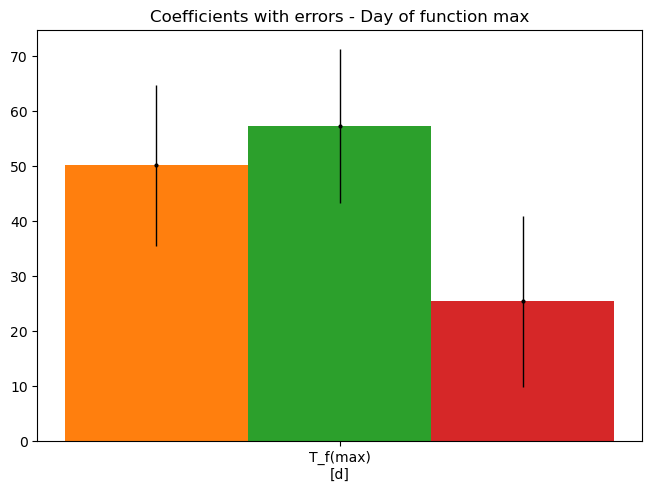

In [101]:
x_arr = np.arange(1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for index, measurement in enumerate([coeff_02_07,coeff_07_12,coeff_12_17]):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement[-1], width,color=color[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    plt.errorbar(x_arr+offset, measurement[-1] , yerr=sig[index][-1],fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, [x_0[-1]]);
# ax.grid()
ax.set_title("Coefficients with errors - Day of function max");

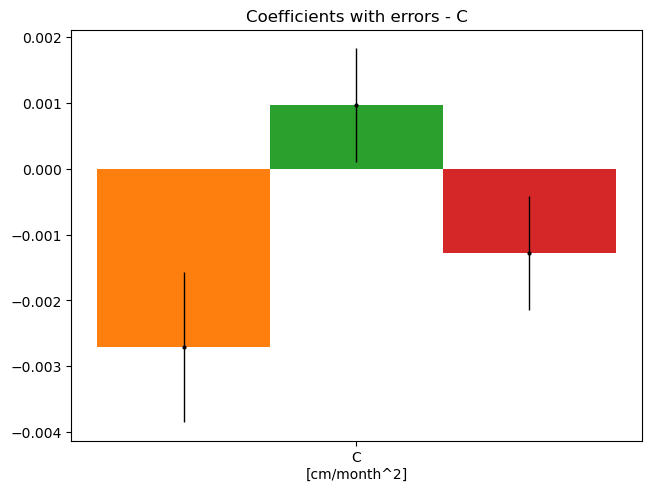

In [102]:
x_arr = np.arange(1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
for index, measurement in enumerate([coeff_02_07,coeff_07_12,coeff_12_17]):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement[2], width,color=color[index])
    # ax.bar_label(rects, padding=3,fmt="%.4f",rotation=90)
    multiplier += 1
    plt.errorbar(x_arr+offset, measurement[2] , yerr=sig[index][2],fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, [x_0[2]]);
# ax.grid()
ax.set_title("Coefficients with errors - C");

\begin{equation}
SNR = \frac{\left|A_1-A_2\right|}{\sigma_{A_1}^2+\sigma_{A_2}^2}
\end{equation}

In [103]:
lst_SNR = []
for i in range(7):
    SNR_i_02_12 = abs(coeff_02_07[i] - coeff_07_12[i]) / np.sqrt(sig[0][i]**2 + sig[1][i]**2) 
    SNR_i_07_17 = abs(coeff_07_12[i] - coeff_12_17[i]) / np.sqrt(sig[1][i]**2 + sig[2][i]**2) 
    lst_SNR.append([SNR_i_02_12,SNR_i_07_17])

In [104]:
table_SNR = list(np.array(lst_SNR).T)
tabulate.tabulate([["02-07 vs 07-12"] + list(table_SNR[0]),
                         ["07-12 vs 12-17"] + list(table_SNR[1]),
                        ],
                    floatfmt=[".2f",".2f",".2f",".2f",".2f",".2f",".2f",".2f"],
                    headers=["Years","A [-]","B [-]","C [-]","D [-]","E [-]","F[-]","T_f(max)[-]"],tablefmt="html")

Years,A [-],B [-],C [-],D [-],E [-],F[-],T_f(max)[-]
02-07 vs 07-12,0.09,0.66,2.57,0.10,1.51,1.27,0.35
07-12 vs 12-17,1.94,2.22,1.84,2.22,8.85,0.47,1.52


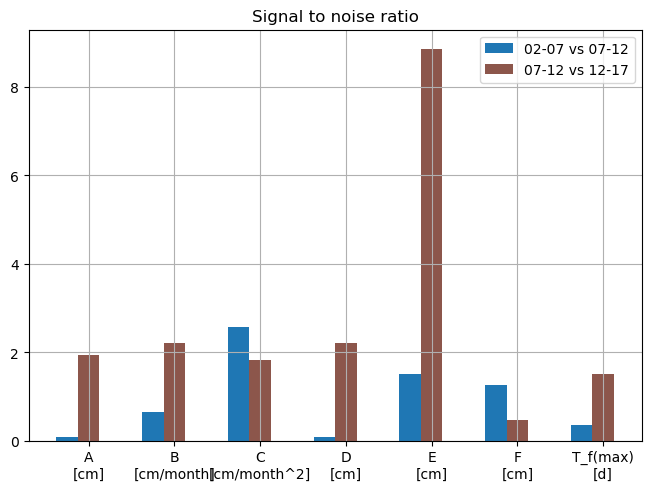

In [105]:
x_arr = np.arange(len(x_0))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

label = ["02-07 vs 07-12","07-12 vs 12-17"]
fig, ax = plt.subplots(layout='constrained')
color=["C0","C5"]
for index, measurement in enumerate(table_SNR):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement, width,color=color[index],label=label[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    # plt.errorbar(x_arr+offset, measurement,fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, x_0);
ax.grid()
ax.set_title("Signal to noise ratio")
ax.legend()

add errors together -> np.sqrt(sig_1,sig_2...) -> absolute errors -> sig noise ratio > 3 -> diff is statistically significant

# repeat trend analysis for graceplotter

In [106]:
df_time_series_graceplotter = df_graceplotter.copy()

for index, date in enumerate(df_time_series_graceplotter.index):
    if index > 0: 
        dt = date - df_time_series_graceplotter.index[index-1]
        df_time_series_graceplotter.loc[date,"months_delta"] =  dt.days//28
    else:
        df_time_series_graceplotter.loc[date,"months_delta"] = 0
df_time_series_graceplotter['t_months'] = df_time_series_graceplotter.months_delta.cumsum().apply(lambda x: int(x))
mid_point_graceplotter = df_time_series_graceplotter.iloc[-1].t_months//2
df_time_series_graceplotter[df_time_series_graceplotter['t_months'] == mid_point_graceplotter]
df_time_series_graceplotter['t_t_0'] = df_time_series_graceplotter.apply(lambda row: (row.t_months-mid_point_graceplotter)-0.5, axis=1)
df_time_series_graceplotter.drop(columns=["Time_S","Time_D_1950","Time_y","Lin","Predic"],inplace=True)
df_time_series_graceplotter.rename(columns={"EWH":"mass_anomaly"},inplace=True)

In [107]:
df_time_series_graceplotter_cropped = df_time_series_graceplotter.loc[:'2017']

## Annual trend

In [108]:
_, A_matrix = evaluate_matrix(param_0, df=df_time_series_graceplotter_cropped, diff=False)
x_bar_graceplotter_cropped = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_graceplotter_cropped.mass_anomaly.values
tabulate.tabulate([x_bar_graceplotter_cropped],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm]
0.811709,-0.0145392,-0.00065081,-1.43789,0.740553


In [109]:
approximated_values_graceplotter_cropped, A_matrix = evaluate_matrix(x=x_bar_graceplotter_cropped, df=df_time_series_graceplotter_cropped, diff=False)

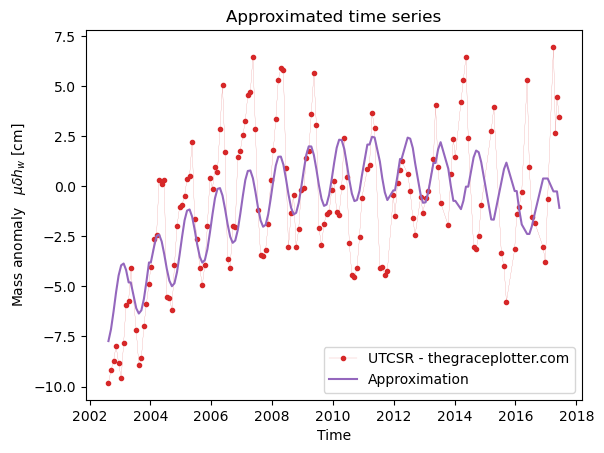

In [110]:
plt.plot(df_time_series_graceplotter_cropped.index, df_time_series_graceplotter_cropped.mass_anomaly,lw=0.1, marker=".",label="UTCSR - thegraceplotter.com", color="C3")
plt.plot(df_time_series_graceplotter_cropped.index, approximated_values_graceplotter_cropped,label="Approximation",color="C4")
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated time series")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## whole time series annual

In [111]:
# prepare initial values
A, B, C, D, E = 1,1,1,1,1
param_0 = np.array([A,B,C,D,E])

In [112]:
_, A_matrix = evaluate_matrix(param_0, df=df_time_series_graceplotter, diff=False)
x_bar_graceplotter = np.linalg.inv(A_matrix.T @ A_matrix) @ A_matrix.T @ df_time_series_graceplotter.mass_anomaly.values
tabulate.tabulate([x_bar_graceplotter],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm]
0.548609,0.0248615,-0.00015839,-1.66298,0.909237


In [113]:
approximated_values_graceplotter, A_matrix = evaluate_matrix(x=x_bar_graceplotter, df=df_time_series_graceplotter, diff=False)

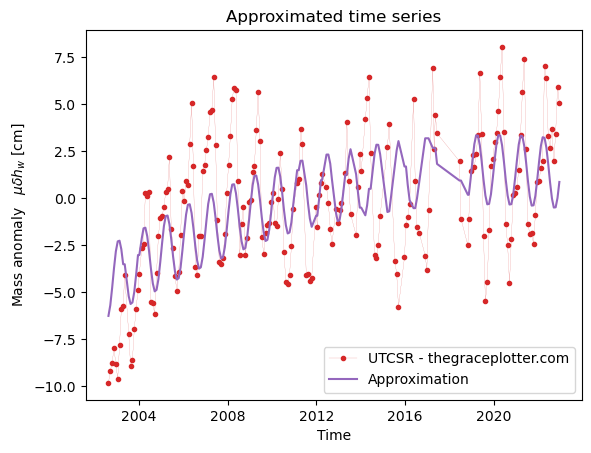

In [114]:
plt.plot(df_time_series_graceplotter.index, df_time_series_graceplotter.mass_anomaly,lw=0.1, marker=".",label="UTCSR - thegraceplotter.com",color="C3")
plt.plot(df_time_series_graceplotter.index, approximated_values_graceplotter,label="Approximation",color="C4")
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated time series")
plt.legend();
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)

## repeat split into 3

In [115]:
df_time_series_graceplotter_02_07 = df_time_series_graceplotter.loc[:"2007-02"]
_, A_matrix_02_07 = evaluate_matrix(param_0, df=df_time_series_graceplotter_02_07,diff=False)
x_bar_02_07 = np.linalg.inv(A_matrix_02_07.T @ A_matrix_02_07) @ A_matrix_02_07.T @ df_time_series_graceplotter_02_07.mass_anomaly.values
tabulate.tabulate([x_bar_02_07],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")
approximated_values_linear_graceplotter_02_07, _ = evaluate_matrix(x=x_bar_02_07, df=df_time_series_graceplotter_02_07, diff=False)

In [116]:
df_time_series_graceplotter_07_12 = df_time_series_graceplotter.loc["2007":"2012-02"]
_, A_matrix_07_12 = evaluate_matrix(param_0, df=df_time_series_graceplotter_07_12,diff=False)
x_bar_07_12 = np.linalg.inv(A_matrix_07_12.T @ A_matrix_07_12) @ A_matrix_07_12.T @ df_time_series_graceplotter_07_12.mass_anomaly.values
tabulate.tabulate([x_bar_07_12],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")
approximated_values_linear_graceplotter_07_12, _ = evaluate_matrix(x=x_bar_07_12, df=df_time_series_graceplotter_07_12, diff=False)

In [117]:
df_time_series_graceplotter_12_17 = df_time_series_graceplotter.loc["2012-01":"2017-2"]
_, A_matrix_12_17 = evaluate_matrix(param_0, df=df_time_series_graceplotter_12_17 ,diff=False)
x_bar_12_17  = np.linalg.inv(A_matrix_12_17.T @ A_matrix_12_17) @ A_matrix_12_17.T @ df_time_series_graceplotter_12_17 .mass_anomaly.values
tabulate.tabulate([x_bar_12_17 ],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

approximated_values_linear_graceplotter_12_17 , _ = evaluate_matrix(x=x_bar_12_17 , df=df_time_series_graceplotter_12_17 , diff=False)

In [118]:
df_time_series_graceplotter_17_20 = df_time_series_graceplotter.loc["2018-03":]
_, A_matrix_17_20 = evaluate_matrix(param_0, df=df_time_series_graceplotter_17_20 ,diff=False)
x_bar_17_20  = np.linalg.inv(A_matrix_17_20.T @ A_matrix_17_20) @ A_matrix_17_20.T @ df_time_series_graceplotter_17_20 .mass_anomaly.values
tabulate.tabulate([x_bar_17_20 ],headers=["A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]"],tablefmt="html")

approximated_values_linear_graceplotter_17_20 , _ = evaluate_matrix(x=x_bar_17_20 , df=df_time_series_graceplotter_17_20 , diff=False)

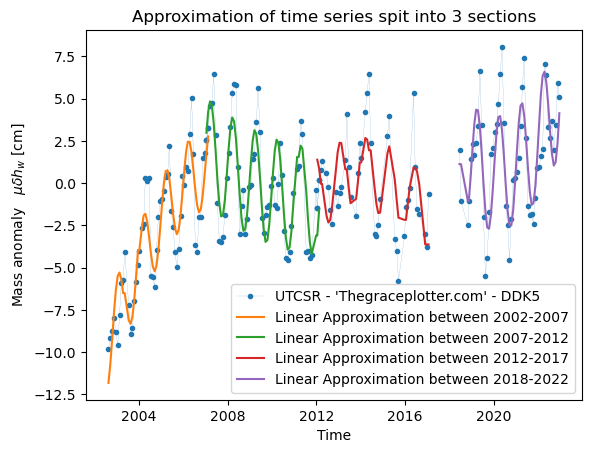

In [119]:
plt.plot(df_time_series_graceplotter_02_07.index, df_time_series_graceplotter_02_07.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_graceplotter_07_12.index, df_time_series_graceplotter_07_12.mass_anomaly,lw=0.1, marker=".",color="C0")
plt.plot(df_time_series_graceplotter_12_17.index, df_time_series_graceplotter_12_17.mass_anomaly,lw=0.1, marker=".",label="UTCSR - 'Thegraceplotter.com' - DDK5",color="C0")
plt.plot(df_time_series_graceplotter_17_20.index, df_time_series_graceplotter_17_20.mass_anomaly,lw=0.1, marker=".",color="C0")

plt.plot(df_time_series_graceplotter_02_07.index, approximated_values_linear_graceplotter_02_07,
         label="Linear Approximation between 2002-2007",color="C1")
plt.plot(df_time_series_graceplotter_07_12.index, approximated_values_linear_graceplotter_07_12,
         label="Linear Approximation between 2007-2012",color="C2")
plt.plot(df_time_series_graceplotter_12_17.index, approximated_values_linear_graceplotter_12_17,
         label="Linear Approximation between 2012-2017",color="C3")
plt.plot(df_time_series_graceplotter_17_20.index, approximated_values_linear_graceplotter_17_20,
         label="Linear Approximation between 2018-2022",color="C4")

plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximation of time series spit into 3 sections")
# plt.legend(bbox_to_anchor=(1,1));
plt.legend(loc="best");

In [120]:
combined_vals_3_lin = np.hstack([approximated_values_linear_graceplotter_02_07,
                                approximated_values_linear_graceplotter_07_12,
                                approximated_values_linear_graceplotter_12_17,
                                approximated_values_linear_graceplotter_17_20])
combined_obs_3_lin = np.hstack([df_time_series_graceplotter_02_07.mass_anomaly.values,
                               df_time_series_graceplotter_07_12.mass_anomaly.values,
                               df_time_series_graceplotter_12_17.mass_anomaly.values,
                               df_time_series_graceplotter_17_20.mass_anomaly.values])

In [121]:
rmse_lin_whole = rmse(combined_vals_3_lin, combined_obs_3_lin)
print(f'The RMSE is {rmse_lin_whole:.2f}cm for a annual trends')

The RMSE is 1.82cm for a annual trends


In [122]:
F = [np.sqrt(D**2 + E**2) for D,E in [x_bar_02_07[-2:],x_bar_07_12[-2:],x_bar_12_17[-2:],x_bar_17_20[-2:]]]
phi = [math.atan2(D,E) for D,E in [x_bar_02_07[-2:],x_bar_07_12[-2:],x_bar_12_17[-2:],x_bar_17_20[-2:]]]
# day_of_func_max = [abs(365.25/4 -365.25 * phi_i/(2*np.pi)) for phi_i in phi]
day_of_func_max = [abs(365.25/4 - 365.25*phi_i/(2*np.pi)) for phi_i in phi]

In [123]:
day_of_func_max

[158.45352611794434, 157.73658323058348, 57.24008702273315, 150.92084519591342]

In [124]:
residuals = combined_obs_3_lin - combined_vals_3_lin
n_p = 5 # number of parameters: A,B,C,D,E
sigma_d = np.sqrt(np.sum(residuals**2/(len(residuals)-n_p)))
print(f"unbiased estimation of sigma_d = {sigma_d:.3f}cm")

unbiased estimation of sigma_d = 1.839cm


In [125]:
matrices = [A_matrix_02_07 , A_matrix_07_12, A_matrix_12_17,A_matrix_17_20]
cov = [sigma_d**2 * np.linalg.inv((A.T @ A)) for A in matrices]
sig = [list(np.sqrt(np.diag(C))) for C in cov]

In [126]:
for i, Cx in enumerate(cov):
    cov_D_E = Cx[3,4]
    cov_E_D = Cx[4,3]
    var_D = Cx[3,3]
    var_E = Cx[4,4]
    sigma_F = np.sqrt((D**2 * var_D + E**2 * var_E + 2 * D * E * cov_D_E)/(D**2 + E**2))
    sigma_phi = np.sqrt(E**2 * var_D + D**2 * var_E - 2 * D * E * cov_D_E)/(D**2 + E**2)
    sigma_phi_day = 365.25 * sigma_phi/(2*np.pi)
    sig[i] += [sigma_F, sigma_phi_day]

In [127]:
coeff_02_07 = list(x_bar_02_07) + [F[0],day_of_func_max[0]]
coeff_07_12 = list(x_bar_07_12) + [F[1],day_of_func_max[1]]
coeff_12_17 = list(x_bar_12_17) + [F[2],day_of_func_max[2]]
coeff_17_20 = list(x_bar_17_20) + [F[3],day_of_func_max[3]]
tabulate.tabulate([["2002-2007"] + coeff_02_07,
                         ["σ"] + sig[0],
                         ["2007-2012"] + coeff_07_12,
                         ["σ"] + sig[1],
                         ["2012-2017"] + list(x_bar_12_17) + [F[2],day_of_func_max[2]],
                         ["σ"] + sig[2],
                         ["2017-2022"] + list(x_bar_17_20) + [F[2],day_of_func_max[3]],
                         ["σ"] + sig[3],
                        ],
                    floatfmt=[".2f",".2f",".2f",".4f",".2f",".2f",".2f",".0f"],
                    headers=["Years","A [cm]","B [cm/month]","C [cm/month^2]","D [cm]","E [cm]","F[cm]","T_f(max)[d]"],tablefmt="html")

Years,A [cm],B [cm/month],C [cm/month^2],D [cm],E [cm],F[cm],T_f(max)[d]
2002-2007,-9.29,-0.36,-0.0031,-2.18,0.96,2.39,158
σ,9.69,0.22,0.0012,0.36,0.36,0.36,15
2007-2012,-1.11,-0.00,0.0007,-2.91,1.33,3.20,158
σ,0.99,0.06,0.0009,0.34,0.34,0.34,14
2012-2017,-0.06,0.08,-0.0027,1.21,-1.82,2.19,57
σ,0.47,0.05,0.0013,0.39,0.41,0.41,16
2017-2022,25.34,-0.62,0.0038,-2.95,1.79,2.19,151
σ,9.15,0.21,0.0012,0.37,0.35,0.35,15


In [128]:
lst_SNR = []
for i in range(7):
    SNR_i_02_12 = abs(coeff_02_07[i] - coeff_07_12[i]) / np.sqrt(sig[0][i]**2 + sig[1][i]**2) 
    SNR_i_07_17 = abs(coeff_07_12[i] - coeff_12_17[i]) / np.sqrt(sig[1][i]**2 + sig[2][i]**2) 
    SNR_i_17_20 = abs(coeff_12_17[i] - coeff_17_20[i]) / np.sqrt(sig[2][i]**2 + sig[3][i]**2) 
    lst_SNR.append([SNR_i_02_12,SNR_i_07_17,SNR_i_17_20])

In [129]:
table_SNR = list(np.array(lst_SNR).T)
tabulate.tabulate([["02-07 vs 07-12"] + list(table_SNR[0]),
                   ["07-12 vs 12-17"] + list(table_SNR[1]),
                   ["12-17 vs 18-22"] + list(table_SNR[2]),
                        ],
                    floatfmt=[".2f",".2f",".2f",".2f",".2f",".2f",".2f",".2f"],
                    headers=["Years","A [-]","B [-]","C [-]","D [-]","E [-]","F[-]","T_f(max)[-]"],tablefmt="html")

Years,A [-],B [-],C [-],D [-],E [-],F[-],T_f(max)[-]
02-07 vs 07-12,0.84,1.56,2.52,1.46,0.73,1.64,0.03
07-12 vs 12-17,0.95,0.98,2.19,7.93,5.90,1.90,4.67
12-17 vs 18-22,2.77,3.19,3.76,7.69,6.71,2.33,4.22


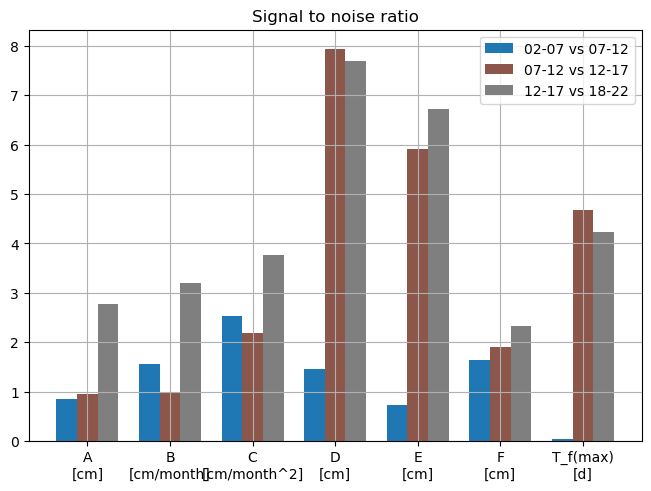

In [130]:
x_arr = np.arange(len(x_0)) # the label locations
width = 0.25  # the width of the bars
multiplier = 0

label = ["02-07 vs 07-12","07-12 vs 12-17","12-17 vs 18-22"]
fig, ax = plt.subplots(layout='constrained')
color=["C0","C5","C7"]
for index, measurement in enumerate(table_SNR):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement, width,color=color[index],label=label[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    # plt.errorbar(x_arr+offset, measurement,fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, x_0);
ax.grid()
ax.set_title("Signal to noise ratio")
ax.legend()

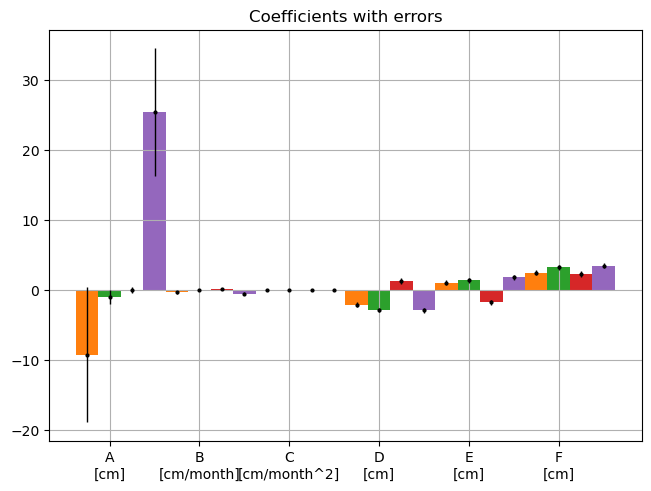

In [131]:
x_arr = np.arange(len(x))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
color=["C1","C2","C3","C4"]
for index, measurement in enumerate([coeff_02_07,coeff_07_12,coeff_12_17,coeff_17_20]):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement[:-1], width,color=color[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    plt.errorbar(x_arr+offset, measurement[:-1] , yerr=sig[index][:-1],fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, x);
ax.grid()
ax.set_title("Coefficients with errors");

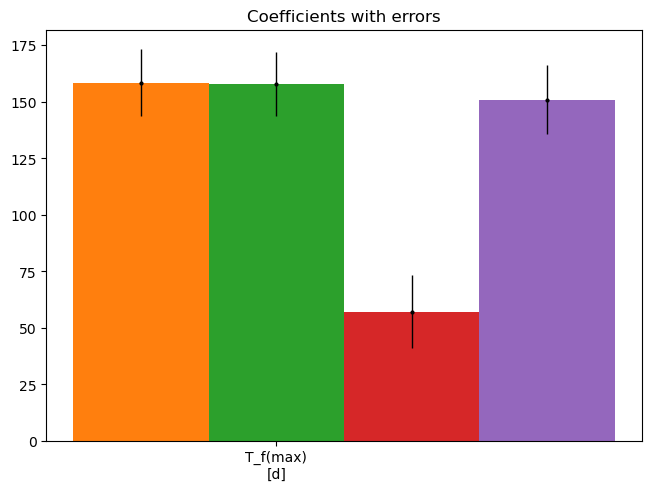

In [132]:
x_arr = np.arange(1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0
n=-1
fig, ax = plt.subplots(layout='constrained')
color=["C1","C2","C3","C4"]
for index, measurement in enumerate([coeff_02_07,coeff_07_12,coeff_12_17,coeff_17_20]):
    offset = width * multiplier
    rects = ax.bar(x_arr + offset, measurement[n], width,color=color[index])
    # ax.bar_label(rects, padding=3,fmt="%.2f",rotation=90)
    multiplier += 1
    plt.errorbar(x_arr+offset, measurement[n] , yerr=sig[index][n],fmt="o", color="k",ms=2,lw=1)
ax.set_xticks(x_arr + width, [x_0[n]]);
# ax.grid()
ax.set_title("Coefficients with errors");

## Compare all of above 

In [133]:
import matplotlib as mpl
cmap = mpl.colormaps["tab10"]

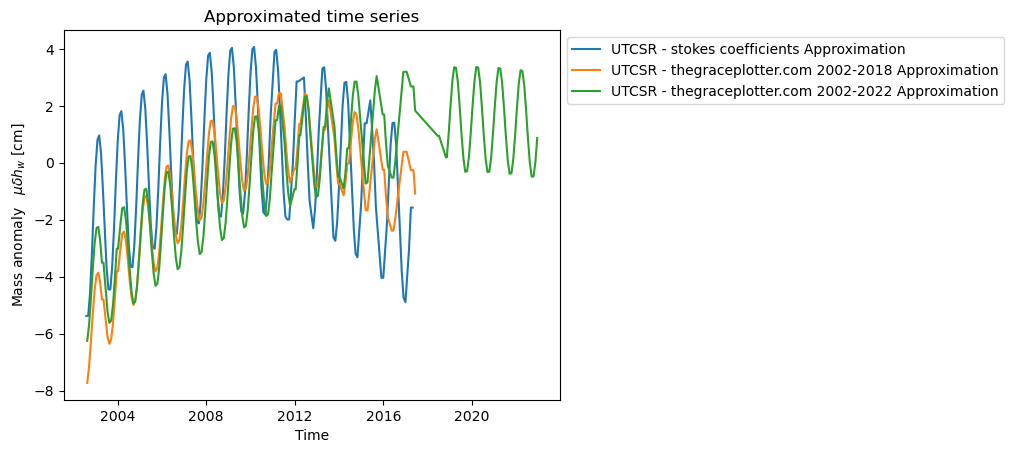

In [134]:
df_lst = [df_time_series_cropped_filtered, df_time_series_graceplotter_cropped, df_time_series_graceplotter]
approx_lst = [approximated_values, approximated_values_graceplotter_cropped, approximated_values_graceplotter] 
name_lst = ["UTCSR - stokes coefficients", "UTCSR - thegraceplotter.com 2002-2018","UTCSR - thegraceplotter.com 2002-2022"]
for index, df, approx, name in zip(range(len(df_lst)),df_lst,approx_lst,name_lst):
    # plt.plot(df.index, df.mass_anomaly,lw=0.01, marker=".",label=name,color=cmap((index)/10), alpha=0.5)
    plt.plot(df.index, approx,label=name+" Approximation",color=cmap((index)/10))
plt.xlabel("Time")
plt.ylabel("Mass anomaly   $\mu \delta h_w$ [cm]")
plt.title("Approximated time series")
plt.legend(bbox_to_anchor=(1,1));
# plt.axhline(0,color='k',alpha=0.4)
# plt.axvline(0,color='k',alpha=0.4)